<a href="https://colab.research.google.com/github/soumyaa-physics/AI-WINTER-SCHOOL-BROWN-2025/blob/main/2025_GNN4ParticlePhysics_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This exercise has two stages. The first one to explore the power of GNNs on classification task and the second for clustering i.e., grouping of energy deposits on the detector subsystems (a rather novel and challenging topic)

We will be using PyTorch for the development and training for the AI models



# Jet type identification using AI (CNN-2D vs. GNNs)
More info:
* https://opendata.cern.ch/record/15013
* https://gitlab.cern.ch/atlas/ATLAS-top-tagging-open-data


We will utilize two different neural network architectures:
- **Convolutional Neural Networks (CNNs)**: These are well-suited for image-like data where spatial relationships are essential.
- **Graph Neural Networks (GNNs)**: These excel at learning from data represented as graphs, making them ideal for particle-level information where constituents of jets can be treated as graph nodes.

The key steps in this notebook include:
1. **Data Loading and Preprocessing**
2. **Exploratory Data Analysis (EDA)**
3. **Model Definition and Training**
4. **Evaluation (ROC Curves)**

**Step 1:** Load the dataset

We will load the dataset using the `h5py` library and separate jets into signal and background categories based on their labels.

We also access only the necessary information from the input file

e.g., fjet_clus_pt, etc..

The dataset contains information about jets in high-energy particle collisions. Each jet is composed of multiple constituents with the following features:
- **Transverse momentum ($p_T$)**: Describes the momentum of the jet in the transverse plane.
- **Pseudorapidity ($\eta$)**: Represents the angle of the jet relative to the beam axis.
- **Azimuthal angle ($\phi$)**: Represents the angle of the jet in the transverse plane (i.e., azimuthal angle).
- **Energy ($E$)**: The total energy of the jet.
- **labels:** Binary labels indicating whether a jet is from the background class (0) or the signal class (1).

In [1]:
## Include the necessary libraries
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')
winter_school_drive = "AI WINTER SCHOOL-SOUMYAA/"
local_path = '/content/drive/My Drive/AI WINTER SCHOOL-SOUMYAA/'
# top_level_path = '/content/drive/Shared drives/AI Winter School (Brown Physics CFPU 2025)/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Set up the module-specific path- 10k examples only
module_path = 'Module 2/ATLAS_TopTagging_OpenData_Small.h5'

In [19]:
full_path = local_path+module_path

In [21]:
with h5py.File(full_path, 'r') as h5_file:
  #get all relevant information from the file
    pt = np.array(h5_file['fjet_clus_pt'])
    eta = np.array(h5_file['fjet_clus_eta'])
    phi = np.array(h5_file['fjet_clus_phi'])
    energy = np.array(h5_file['fjet_clus_E'])
    labels = np.array(h5_file['labels'])
    weights = np.array(h5_file['training_weights'])

In [22]:
# Normalize constituent energy by the total jet energy
total_jet_energy = np.sum(energy, axis=1, keepdims=True)
normalized_energy = energy / total_jet_energy

We have a binary classification problem and we want to check how balanced are the two classes

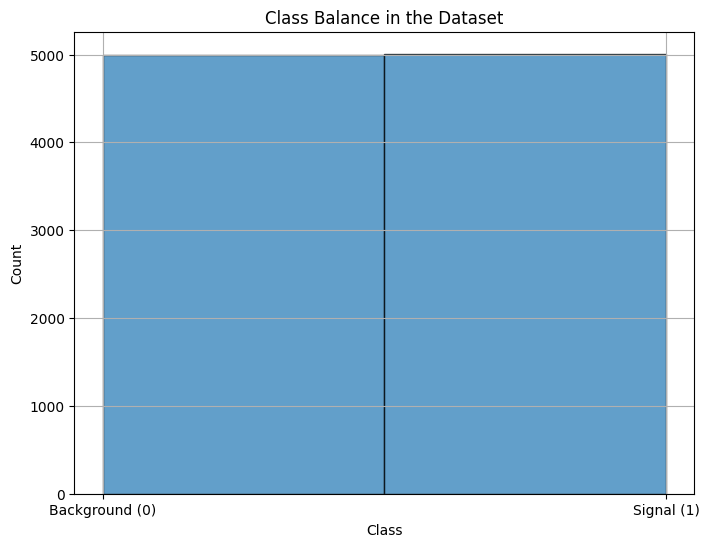

In [26]:
# Class balance plot-> same importance to signal and background-> to not have a bias
plt.figure(figsize=(8, 6))
plt.hist(labels, bins=2, edgecolor='black', alpha=0.7) #alpha is the opacity
plt.xticks([0, 1], ['Background (0)', 'Signal (1)'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Balance in the Dataset')
plt.grid(True)
plt.show()

**Step 2:** Filtering Constituents
* Constituents with non-positive transverse momentum (pt) or energy are considered unphysical and are removed. -> when detector reconstruction fails
* This step ensures that only valid physical data is processed further.

**Distributions of Physical Quantities**

Before training the models, it's essential to understand the input data. We will plot the distributions of the following quantities for both signal and background jets.

By visualizing these distributions, we can gain info about the differences between signal and background jets.

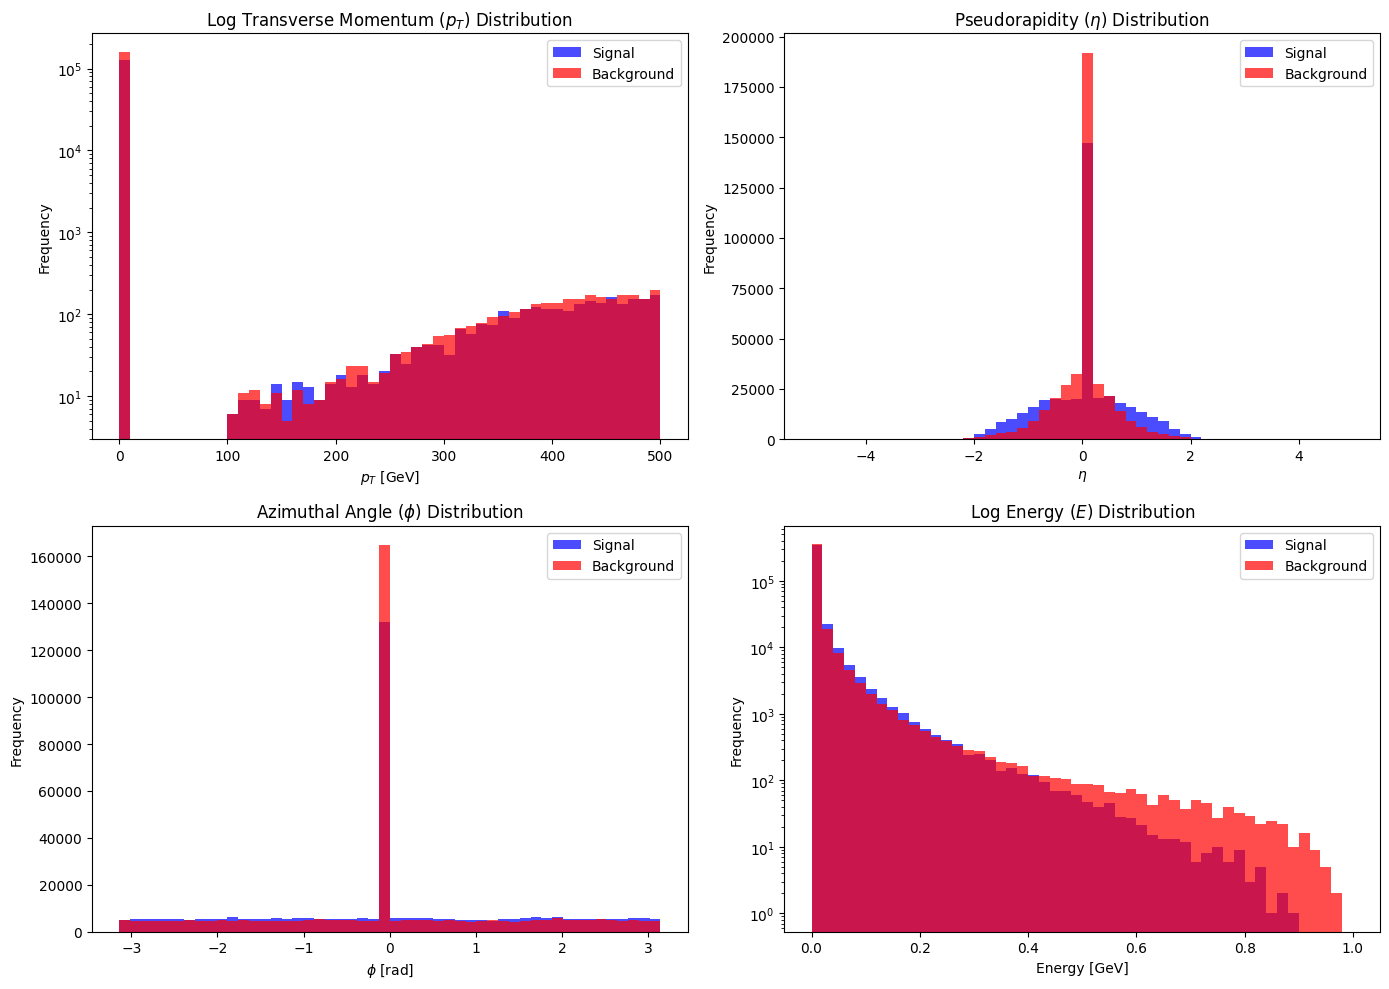

In [25]:
# Separate signal and background based on labels
signal_mask = labels == 1
background_mask = labels == 0

# Plot distributions for signal and background
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# pT distribution
axs[0, 0].hist(pt[signal_mask].flatten(), bins=50, range=(0, 500), alpha=0.7, label='Signal', color='blue')
axs[0, 0].hist(pt[background_mask].flatten(), bins=50, range=(0, 500), alpha=0.7, label='Background', color='red')
axs[0, 0].set_title('Log Transverse Momentum ($p_T$) Distribution')
axs[0, 0].set_xlabel('$p_T$ [GeV]')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_yscale('log')
axs[0, 0].legend()

# Eta distribution
axs[0, 1].hist(eta[signal_mask].flatten(), bins=50, range=(-5, 5), alpha=0.7, label='Signal', color='blue')
axs[0, 1].hist(eta[background_mask].flatten(), bins=50, range=(-5, 5), alpha=0.7, label='Background', color='red')
axs[0, 1].set_title('Pseudorapidity ($\eta$) Distribution')
axs[0, 1].set_xlabel('$\eta$')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].legend()

# Phi distribution
axs[1, 0].hist(phi[signal_mask].flatten(), bins=50, range=(-np.pi, np.pi), alpha=0.7, label='Signal', color='blue')
axs[1, 0].hist(phi[background_mask].flatten(), bins=50, range=(-np.pi, np.pi), alpha=0.7, label='Background', color='red')
axs[1, 0].set_title('Azimuthal Angle ($\phi$) Distribution')
axs[1, 0].set_xlabel('$\phi$ [rad]')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].legend()

# Energy distribution
axs[1, 1].hist(normalized_energy[signal_mask].flatten(), bins=50, range=(0, 1), alpha=0.7, label='Signal', color='blue')
axs[1, 1].hist(normalized_energy[background_mask].flatten(), bins=50, range=(0, 1), alpha=0.7, label='Background', color='red')
axs[1, 1].set_title('Log Energy ($E$) Distribution')
axs[1, 1].set_xlabel('Energy [GeV]')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_yscale('log')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [27]:
mask = (pt > 0) & (energy > 0)
pt_filtered = np.where(mask, pt, 0)
eta_filtered = np.where(mask, eta, 0)
phi_filtered = np.where(mask, phi, 0)
energy_filtered = np.where(mask, normalized_energy, 0)


# Define max_constits before using it in the CNN model
max_constits = 80  # Maximum number of constituents to consider for each jet

# **The remaining steps are specific to CNN-2D**




**Step 3:** Preprocessing
* Preprocessing involves three main tasks:
we do not have a direction bias
clusters produced at any direction are the same
	1.	Centering: The η and φ values are shifted so that the leading constituent (the one with the highest transverse momentum) is positioned at (0, 0) in the η-φ plane.
	2.	Wrapping φ values: The φ values are wrapped into the range [−π, π], ensuring circular symmetry.
	3.	Energy Normalization: The energy of each constituent is divided by the total energy of the jet, resulting in values between 0 and 1.
* The maximum number of constituents per jet is limited to *max_constits = 80*, and jets with fewer constituents are padded with zeros.

In [28]:
def preprocess(pt, eta, phi, energy, max_constits=80):
    num_jets = len(pt)
    pt_padded = np.zeros((num_jets, max_constits))
    eta_padded = np.zeros((num_jets, max_constits))
    phi_padded = np.zeros((num_jets, max_constits))
    energy_padded = np.zeros((num_jets, max_constits))
    valid_jet_indices = []

    for i in range(num_jets):
        valid_constits = (pt[i] > 0) & (energy[i] > 0)
        pt_valid = pt[i][valid_constits]
        eta_valid = eta[i][valid_constits]
        phi_valid = phi[i][valid_constits]
        energy_valid = energy[i][valid_constits]

        num_constits = min(len(pt_valid), max_constits)

        if num_constits > 0:
            valid_jet_indices.append(i)
            eta_valid -= eta_valid[0]
            phi_valid = (phi_valid - phi_valid[0] + np.pi) % (2 * np.pi) - np.pi
            total_energy = np.sum(energy_valid) + 1e-8
            energy_valid /= total_energy
            pt_padded[i, :num_constits] = pt_valid[:num_constits]
            eta_padded[i, :num_constits] = eta_valid[:num_constits]
            phi_padded[i, :num_constits] = phi_valid[:num_constits]
            energy_padded[i, :num_constits] = energy_valid[:num_constits]

    log_pt = np.log(pt_padded + 1e-8)
    preprocessed_data = np.stack([eta_padded, phi_padded, log_pt, energy_padded], axis=-1)
    return preprocessed_data, valid_jet_indices

preprocessed_data, valid_jet_indices = preprocess(pt_filtered, eta_filtered, phi_filtered, energy_filtered)

**Study the effect of the preprocessing**

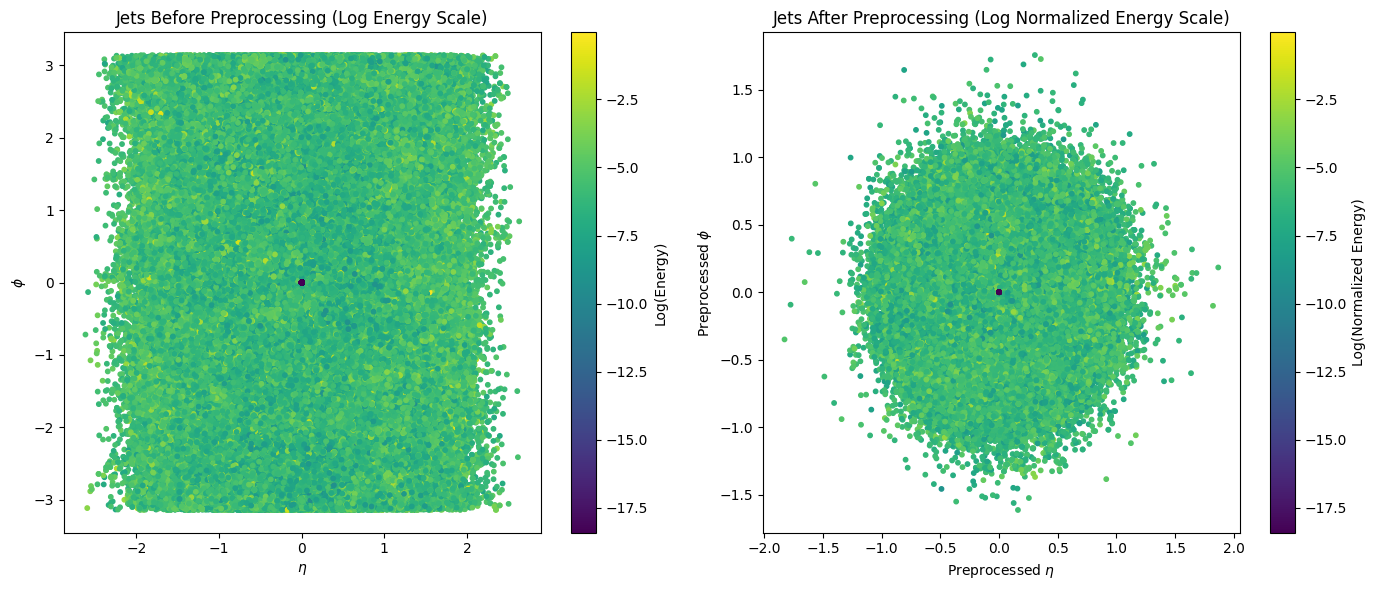

In [29]:
# Plot multiple jets before and after preprocessing
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Before preprocessing
sc1 = axs[0].scatter(eta_filtered.flatten(), phi_filtered.flatten(),
                      c=np.log(energy_filtered.flatten() + 1e-8), cmap='viridis', s=10)
axs[0].set_title('Jets Before Preprocessing (Log Energy Scale)')
axs[0].set_xlabel('$\eta$')
axs[0].set_ylabel('$\phi$')
plt.colorbar(sc1, ax=axs[0], label='Log(Energy)')

# After preprocessing
sc2 = axs[1].scatter(preprocessed_data[..., 0].flatten(), preprocessed_data[..., 1].flatten(),
                      c=np.log(preprocessed_data[..., 3].flatten() + 1e-8), cmap='viridis', s=10)
axs[1].set_title('Jets After Preprocessing (Log Normalized Energy Scale)')
axs[1].set_xlabel('Preprocessed $\eta$')
axs[1].set_ylabel('Preprocessed $\phi$')
plt.colorbar(sc2, ax=axs[1], label='Log(Normalized Energy)')

plt.tight_layout()
plt.show()

**Step 4:** Creating PyTorch Tensors


**What is a Batch?**

A **batch** refers to a subset of the dataset that is processed by the neural network at one time during training. Instead of feeding the entire dataset at once, we divide the data into smaller batches, which:
- Reduces memory usage.
- Allows for efficient computation using parallel hardware (e.g., GPUs).
- Provides a smoother gradient update compared to using the entire dataset (stochastic gradient descent).

**How are Batches Used?**

At each iteration:
1. A batch of data is fed into the network.
2. The forward pass computes the output for this batch.
3. The loss is calculated based on the batch output and true labels.
4. The network parameters are updated using backpropagation.

In PyTorch, we use the `DataLoader` class to handle batching.

* The processed data is converted into PyTorch tensors, which are the primary data structures used for training deep learning models.
* A TensorDataset is created, and it is split into training and testing sets using an 80/20 ratio.



But first, we need to include the necessary PyTorch packages (https://pytorch.org/)

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

#X_tensor = torch.tensor(preprocessed_data, dtype=torch.float32).permute(0, 2, 1).unsqueeze(3)
lognorm_energy = preprocessed_data[..., 3]  # 4th feature corresponds to normalized energy

# Reshape into a single-channel image (num_samples, 1, eta_bins, phi_bins)
X_tensor = torch.tensor(lognorm_energy, dtype=torch.float32).unsqueeze(1)  # Shape: (num_samples, 1, 80, 80)

y_tensor = torch.tensor(labels, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [31]:
# Extract eta, phi, and log-normalized energy from preprocessed data
eta = preprocessed_data[..., 0]  # eta is the 1st feature
phi = preprocessed_data[..., 1]  # phi is the 2nd feature
lognorm_energy = preprocessed_data[..., 3]  # log-normalized energy is the 4th feature

# Define grid resolution (bins for eta and phi)
num_bins = 10
eta_min, eta_max = -2, 2
phi_min, phi_max = -2, 2

# Create grid and fill with log-normalized energy
X_images = []
for i in range(lognorm_energy.shape[0]):  # Loop over each jet
    H, _, _ = np.histogram2d(
        eta[i], phi[i], bins=num_bins, range=[[eta_min, eta_max], [phi_min, phi_max]], weights=lognorm_energy[i]
    )
    X_images.append(H)

X_images = np.array(X_images)  # Shape: (num_samples, 80, 80)
X_tensor = torch.tensor(X_images, dtype=torch.float32).unsqueeze(1)  # Add channel dimension: (num_samples, 1, 80, 80)

y_tensor = torch.tensor(labels, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

**Step 5:** Defining the CNN Model

Convolutional Neural Networks (CNNs) are commonly used for image-like data. In this case, we treat the constituent features of jets as an image with one channels:

- **Input channels**: Each channel corresponds to a preprocessed feature. In this case we only use $E$, normalized with respect to the jet momentum.
- **Convolutional layers**: These layers extract spatial patterns from the input.
- **Fully connected layers**: These layers combine the extracted features to make the final classification.


**General structure of the CNN architecture**
1. **Convolutional Layers**: These layers apply filters (kernels) to the input data to extract spatial features.
2. **Activation Function (ReLU)**: After each convolution, we apply the ReLU activation function to introduce non-linearity.
3. **Pooling Layer**: The pooling layer reduces the spatial dimensions of the feature maps, which helps in reducing computation and preventing overfitting.
4. **Fully Connected Layers**: These layers combine the extracted features to make the final classification.
5. **Sigmoid Activation**: The output layer uses a sigmoid activation function to produce a probability score between 0 and 1.


In [33]:
class CNNJetTagger(nn.Module):
    def __init__(self):
        super(CNNJetTagger, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=(1, 1)) #(1 input, 32 output, 3by3 filter, padding 1,1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1)) #padding is required at edges, put a few pixels as 0
        self.pool = nn.MaxPool2d(kernel_size=(2, 2)) #max pooling by taking a 2x2 square
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * (num_bins // 4) * (num_bins // 4), 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

**Brief explanation of most important parts of the code:**

*nn.Conv2d(in_channels, out_channels, kernel_size, padding)* is a 2D convolutional layer.
- in_channels = 1: This means the input image has a single channel (log-normalized energy in your case).
- out_channels = 32: The first convolutional layer outputs 32 feature maps by applying 32 different filters.
- kernel_size = (3, 3): This specifies that each filter is a 3x3 matrix sliding over the input image.
- padding = (1, 1): This adds a padding of 1 pixel around the input to maintain its original size after convolution.

*nn.MaxPool2d(kernel_size=(2, 2)):* This is a max-pooling layer that reduces the spatial dimensions of the input by half.
- It slides a 2x2 window over the input and takes the maximum value in each window.
- This operation helps reduce the computational complexity and extract dominant features.

*nn.Flatten():* This layer flattens the 2D feature maps into a 1D vector to be fed into fully connected layers.
- If the input to the flatten layer is of shape [batch_size, 64, 20, 20], it will be reshaped to [batch_size, 64 * 20 * 20].



**Step 6: GPU or CPU?**

The code checks whether a GPU is available using *torch.cuda.is_available()*. If a GPU is found, the model and data are processed on the GPU; otherwise, it falls back to the CPU.

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNJetTagger().to(device)

**Visualization of CNN Architecture**

Below is a visualization of the CNN architecture. It shows how data flows through the network, including the convolutional layers, pooling layers, and fully connected layers.

In [35]:
from torchsummary import summary

model = CNNJetTagger()
summary(model, input_size=(1, num_bins, num_bins))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 10, 10]             320
         MaxPool2d-2             [-1, 32, 5, 5]               0
            Conv2d-3             [-1, 64, 5, 5]          18,496
         MaxPool2d-4             [-1, 64, 2, 2]               0
           Flatten-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
            Linear-7                    [-1, 1]             129
           Sigmoid-8                    [-1, 1]               0
Total params: 51,841
Trainable params: 51,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.20
Estimated Total Size (MB): 0.25
----------------------------------------------------------------


**Notes/explanations:**

- Input Size (MB): The memory required to store the input data during training.
- Forward/Backward Pass Size (MB): The memory used during the forward and backward passes of the neural network.
- Params Size (MB): The memory required to store the learnable parameters of the model.
- Estimated Total Size (MB): This is the sum of the input size, forward/backward pass size, and parameter size, giving an estimate of the total memory required by the model.

**Step 7: Training the Model**
* The model is trained using binary cross-entropy loss (BCELoss) and the Adam optimizer.
* The training loop runs for 10 epochs, and after each epoch, the average loss is recorded and printed.

**Loss Function: Binary Cross-Entropy**

Since this is a binary classification problem (signal vs. background), we use the **Binary Cross-Entropy Loss**.

**Mathematical Definition**
The binary cross-entropy loss for a single sample is given by:


$\text{BCE}(y, \hat{y}) = - \left[ y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \right]$

Where:
- $y$ is the true label $y = 1$ for signal, $y = 0$ for background).
- $\hat{y}$ is the predicted probability of the jet being a signal (output of the network).

The total loss over a batch is the mean of individual sample losses:

$\text{Loss}_{\text{batch}} = \frac{1}{N} \sum_{i=1}^{N} \text{BCE}(y_i, \hat{y}_i)$

In PyTorch, we use the `BCELoss` class to compute this loss automatically.


In [49]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/10, Loss: 0.6776
Epoch 2/10, Loss: 0.6770
Epoch 3/10, Loss: 0.6767
Epoch 4/10, Loss: 0.6768
Epoch 5/10, Loss: 0.6759
Epoch 6/10, Loss: 0.6764
Epoch 7/10, Loss: 0.6755
Epoch 8/10, Loss: 0.6755
Epoch 9/10, Loss: 0.6755
Epoch 10/10, Loss: 0.6750


**Plot Loss vs. epoch:** Shows how well the model is learning over time.

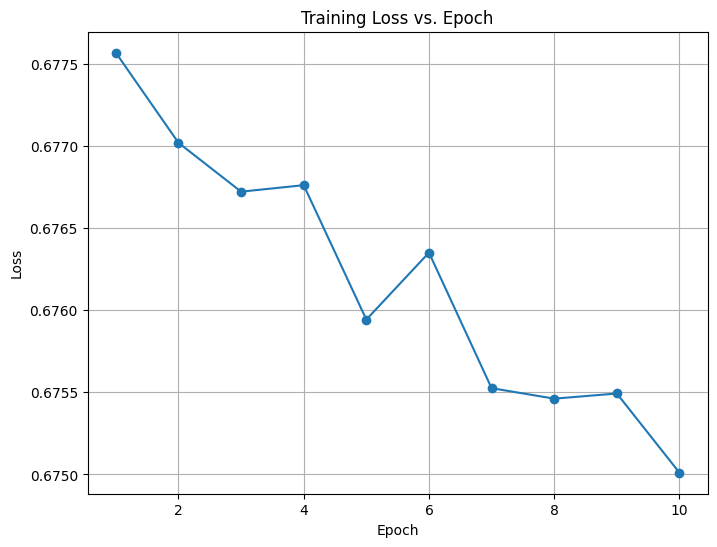

In [51]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.grid(True)
plt.savefig('loss_vs_epoch.png')
plt.show()
#the up and down is probably due to statistical fluctuations


**Step 7: Performance metrics**

After training, the model is evaluated on the test set by generating predictions.
* The ROC curve is plotted, showing the trade-off between the true positive rate (TPR) and false positive rate (FPR) at different classification thresholds.
* The AUC (Area Under the Curve) is computed to summarize the performance of the model.

Skickit learn is a very useful package for such operations

In [52]:
from sklearn.metrics import roc_curve, auc

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).cpu().numpy()
        y_true.extend(y_batch.numpy())
        y_pred.extend(outputs)

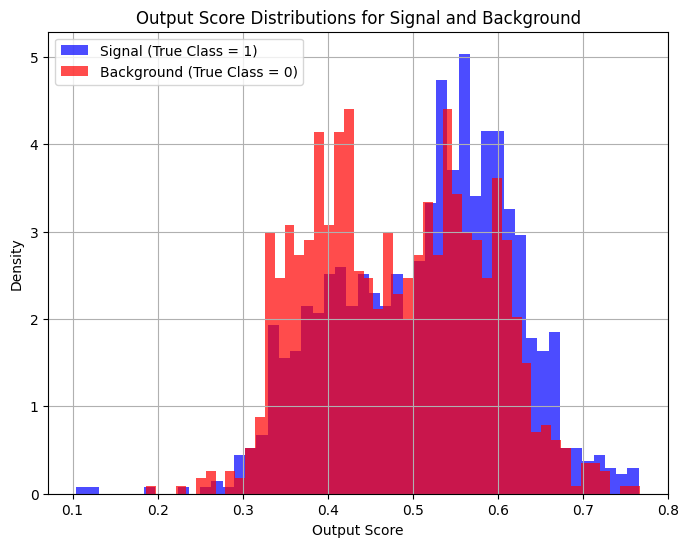

In [53]:
# Convert y_true and y_pred to numpy arrays and flatten them
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

# Separate output scores for signal (y_true = 1) and background (y_true = 0)
y_pred_signal = y_pred[y_true == 1]
y_pred_background = y_pred[y_true == 0]

# Plot histograms for signal and background
plt.figure(figsize=(8, 6))

# Histogram of output scores for signal events
plt.hist(y_pred_signal, bins=50, alpha=0.7, label='Signal (True Class = 1)', color='blue', density=True)

# Histogram of output scores for background events
plt.hist(y_pred_background, bins=50, alpha=0.7, label='Background (True Class = 0)', color='red', density=True)

plt.xlabel('Output Score')
plt.ylabel('Density')
plt.title('Output Score Distributions for Signal and Background')
plt.legend()
plt.grid(True)
plt.show()

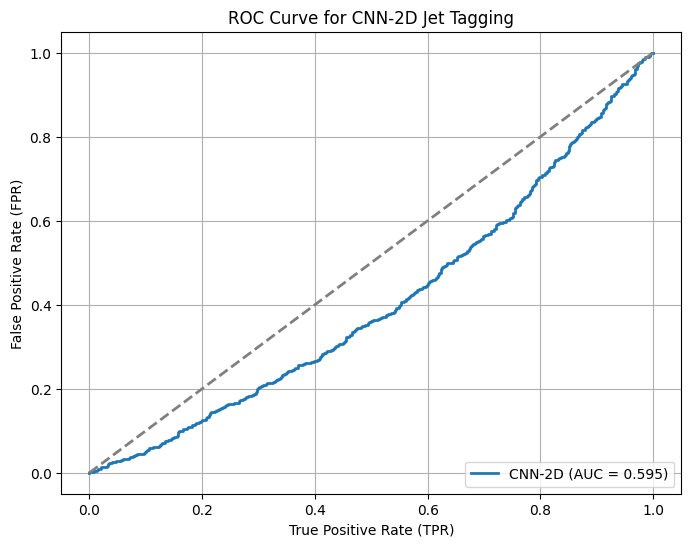

In [54]:
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(tpr, fpr, label=f'CNN-2D (AUC = {roc_auc:.3f})', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('True Positive Rate (TPR)')
plt.ylabel('False Positive Rate (FPR)')
plt.title('ROC Curve for CNN-2D Jet Tagging')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve_cnn2d.png')
plt.show()

# **Graph Neural Network-based algorithm**

**Step 0:** Include tools *pytorch_ geometric* that can make the development of GNNs very straight forward

In [46]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 44.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 19.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 39.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.6/886.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.3 MB/s eta 0:00:00


**Step 1:** Preprocessing for GNN

Before feeding the data into a Graph Neural Network (GNN), it is essential to prepare the data in a way that is suitable for graph-based learning. Unlike the CNN preprocessing (where we used centering, rotation, and normalization), the preprocessing for GNN focuses on scaling and normalizing the features of the nodes to ensure that the network can efficiently learn patterns without being biased by large variations in feature magnitudes.

In this step, we:
1.	Pad the number of constituents for each jet to a fixed size (max_constits) to ensure uniform input shapes.
2.	Scale each feature (transverse momentum, pseudorapidity, azimuthal angle, and energy) so that they have zero mean and unit variance. This step improves the stability of the training process and ensures that features contribute equally to the learning process.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def preprocess_for_GNN(pt, eta, phi, energy, max_constits=80):
    """
    Preprocess the input data for GNN by:
    1. Padding to ensure a uniform number of constituents per jet.
    2. Scaling each feature to have zero mean and unit variance.
    """
    num_jets = len(pt)

    # Initialize padded arrays
    pt_padded = np.zeros((num_jets, max_constits))
    eta_padded = np.zeros((num_jets, max_constits))
    phi_padded = np.zeros((num_jets, max_constits))
    energy_padded = np.zeros((num_jets, max_constits))

    for i in range(num_jets):
        num_constits = min(len(pt[i]), max_constits)
        pt_padded[i, :num_constits] = pt[i][:num_constits]
        eta_padded[i, :num_constits] = eta[i][:num_constits]
        phi_padded[i, :num_constits] = phi[i][:num_constits]
        energy_padded[i, :num_constits] = energy[i][:num_constits]

    # Normalize each feature to have zero mean and unit variance
    pt_scaled = (pt_padded - np.mean(pt_padded)) / np.std(pt_padded)
    eta_scaled = (eta_padded - np.mean(eta_padded)) / np.std(eta_padded)
    phi_scaled = (phi_padded - np.mean(phi_padded)) / np.std(phi_padded)
    energy_scaled = (energy_padded - np.mean(energy_padded)) / np.std(energy_padded)

    return pt_scaled, eta_scaled, phi_scaled, energy_scaled

**Step 2:** Creating the Graph

In this step, we convert the jets into graphs, where:
*	Each constituent becomes a node in the graph.
*	Edges are created between all pairs of nodes, forming a fully connected graph.
*	Node features are represented by the four attributes: transverse momentum (pt), pseudorapidity ($\eta$), azimuthal angle ($\phi$), and energy.


A more technical explanation:
1.	Node Features: Each constituent is treated as a node with four features: [pt, eta, phi, energy].
2.	Edges: We assume a fully connected graph, where each node is connected to every other node. This is achieved using torch.combinations.
3.	Graph Labels: Each graph (jet) is assigned a label indicating whether it belongs to the background class (0) or signal class (1).
4.	PyTorch Geometric Data Object: Each graph is represented as a Data object from PyTorch Geometric, which stores the node features, edge information, and labels.

In [ ]:
def create_graph_data(pt, eta, phi, energy, labels):
    """
    Convert the jet constituents into graph data.
    Each constituent becomes a node, and edges are created as fully connected.
    """
    data_list = []
    num_samples = pt.shape[0]

    for i in range(num_samples):
        num_constituents = pt[i].shape[0]

        # Create node features: [pt, eta, phi, energy]
        x = torch.tensor(np.stack([pt[i], eta[i], phi[i], energy[i]], axis=-1), dtype=torch.float32)

        # Fully connected graph (edges between all constituents)
        edge_index = torch.combinations(torch.arange(num_constituents), r=2).t()

        # Label for the graph
        y = torch.tensor(labels[i], dtype=torch.float32).unsqueeze(0)

        # Create Data object for PyTorch Geometric
        graph = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(graph)

    return data_list

**Step 3:** Defining the GNN Model

The GNN model consists of:
1.	Graph convolutional layers (GCNConv), which aggregate information from neighboring nodes.
2.	Global mean pooling, which aggregates node features into a graph-level representation.
3.	Fully connected layers, which process the graph-level representation and output a probability for binary classification.

In [ ]:
class GNNJetTagger(nn.Module):
    def __init__(self):
        super(GNNJetTagger, self).__init__()
        self.conv1 = GCNConv(in_channels=4, out_channels=32)
        self.conv2 = GCNConv(in_channels=32, out_channels=64)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, edge_index, batch):
        """
        Forward pass for the GNN model:
        1. Apply two graph convolutional layers with ReLU activation.
        2. Use global mean pooling to aggregate node features into a graph-level representation.
        3. Pass the graph representation through fully connected layers.
        4. Apply sigmoid activation to output a probability for binary classification.
        """
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Global pooling
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

**The most important part of the above code: The GCN Layer**

A GCN layer applies the following operation:


$h_i^{(l+1)} = \sigma \left( \sum_{j \in \mathcal{N}(i)} \frac{1}{\sqrt{d_i d_j}} W^{(l)} h_j^{(l)} + b^{(l)} \right)$


Where:
- $h_i^{(l)}$  is the feature vector of node  $i$  at layer  $l$
- $\mathcal{N}(i)$  is the set of neighbors of node  $i$
- $d_i$  is the degree of node  $i$  (number of neighbors)
- $W^{(l)}$  and  $b^{(l)}$  are the learnable weight matrix and bias vector for layer  $l$
- $\sigma$  is the activation function (ReLU in this case).


**Build and Visualize the graphs**

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx

max_constits = 80
pt_scaled, eta_scaled, phi_scaled, energy_scaled = preprocess_for_GNN(pt_filtered, eta_filtered, phi_filtered, energy_filtered, max_constits)
data_list = create_graph_data(pt_scaled, eta_scaled, phi_scaled, energy_scaled, labels)

# Find indices for signal and background graphs
signal_indices = [i for i, data in enumerate(data_list) if data.y.item() == 1]
background_indices = [i for i, data in enumerate(data_list) if data.y.item() == 0]

# Select one signal and one background graph for visualization
signal_graph = data_list[signal_indices[0]]
background_graph = data_list[background_indices[0]]

# Convert to NetworkX format for visualization
signal_nx = to_networkx(signal_graph, node_attrs=['x'], edge_attrs=None)
background_nx = to_networkx(background_graph, node_attrs=['x'], edge_attrs=None)

# Plot signal graph
plt.figure(figsize=(8, 6))
nx.draw(signal_nx, with_labels=False, node_size=50, node_color='red')
plt.title('Signal Graph')
plt.show()

# Plot background graph
plt.figure(figsize=(8, 6))
nx.draw(background_nx, with_labels=False, node_size=50, node_color='blue')
plt.title('Background Graph')
plt.show()

**Step 4:** Preparing Data for Training

In [ ]:


# Split data into training and testing sets
train_size = int(0.8 * len(data_list))
test_size = len(data_list) - train_size
train_data, test_data = torch.utils.data.random_split(data_list, [train_size, test_size])

# Create DataLoader for training and testing
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

**Step 5:** Train the GNN Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNJetTagger().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 4
losses = []  # List to store the average loss for each epoch

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0  # Initialize running loss for the epoch

    for batch in train_loader:
        batch = batch.to(device)  # Move the batch to the selected device (CPU/GPU)
        optimizer.zero_grad()  # Reset gradients
        outputs = model(batch.x, batch.edge_index, batch.batch).squeeze()  # Forward pass
        loss = criterion(outputs, batch.y)  # Compute the binary cross-entropy loss
        loss.backward()  # Backpropagation (compute gradients)
        optimizer.step()  # Update the model's parameters
        running_loss += loss.item()  # Accumulate loss for the epoch

    avg_loss = running_loss / len(train_loader)  # Compute average loss for the epoch
    losses.append(avg_loss)  # Store the average loss for plotting
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")



In [ ]:
# Plot the loss vs. epoch curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), losses, marker='o', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch for GNN')
plt.grid(True)
plt.show()

**Step 6:** Evaluate the GNN Model

In [ ]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        outputs = model(batch.x, batch.edge_index, batch.batch).cpu().numpy()
        y_true.extend(batch.y.cpu().numpy())
        y_pred.extend(outputs)

In [ ]:
# Convert y_true and y_pred to numpy arrays and flatten them
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

# Separate output scores for signal (y_true = 1) and background (y_true = 0)
y_pred_signal = y_pred[y_true == 1]
y_pred_background = y_pred[y_true == 0]

# Plot histograms for signal and background
plt.figure(figsize=(8, 6))

# Histogram of output scores for signal events
plt.hist(y_pred_signal, bins=50, alpha=0.7, label='Signal (True Class = 1)', color='blue', density=True)

# Histogram of output scores for background events
plt.hist(y_pred_background, bins=50, alpha=0.7, label='Background (True Class = 0)', color='red', density=True)

plt.xlabel('Output Score')
plt.ylabel('Density')
plt.title('Output Score Distributions for Signal and Background')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(tpr, fpr, label=f'GNN (AUC = {roc_auc:.3f})', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC Curve for GNN Jet Tagging')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()